# Analyse de Sentiments Avancée : TF-IDF vs BERT

**Projet** : Classification de sentiments sur des avis clients (Dataset Yelp)

**Objectif** : Comparer deux approches de classification de sentiments :
- **Baseline** : TF-IDF + Régression Logistique
- **Deep Learning** : Fine-tuning DistilBERT

**Classes** :
- 🔴 Négatif (1-2 étoiles)
- 🟡 Neutre (3 étoiles)
- 🟢 Positif (4-5 étoiles)

---


# 1️⃣ Configuration de l'Environnement


## 1.1 Installation des Dépendances


In [ ]:
# Installation silencieuse des packages nécessaires
%pip install -q transformers datasets scikit-learn matplotlib seaborn pandas torch langdetect wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## 1.2 Imports


In [ ]:
# ============================================================
# IMPORTS PRINCIPAUX
# ============================================================

# Data manipulation
import numpy as np
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Machine Learning - Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    cohen_kappa_score,
    matthews_corrcoef
)
from sklearn.utils.class_weight import compute_class_weight

# Deep Learning - PyTorch & Transformers
import torch
from torch import nn
from datasets import load_dataset, Dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    DistilBertConfig,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)

# Utils
from langdetect import detect, LangDetectException
from tqdm.auto import tqdm
import joblib
import os

# Configuration visuelle
sns.set_style('whitegrid')
pd.set_option('display.max_colwidth', 150)

print("✅ Imports terminés avec succès.")

✅ Imports terminés avec succès.


## 1.3 Configuration Hardware & Reproductibilité


In [ ]:
# ============================================================
# CONFIGURATION
# ============================================================

# Seed pour reproductibilité
SEED = 42

def set_seed(seed=SEED):
    """Fixe les graines aléatoires pour des résultats reproductibles."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

# Détection du hardware
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"🔧 Seed fixée à : {SEED}")
print(f"🖥️  Device : {DEVICE}")
print(f"📦 PyTorch version : {torch.__version__}")


🔧 Seed fixée à : 42
🖥️  Device : cuda
📦 PyTorch version : 2.9.0+cu126


---
# 2️⃣ Chargement et Préparation des Données


## 2.1 Paramètres Globaux


In [ ]:
# ============================================================
# PARAMÈTRES DU PROJET
# ============================================================

# Taille de l'échantillon (même dataset pour les 2 modèles)
SAMPLE_SIZE = 100000

# Ratio train/test
TEST_SIZE = 0.2

# Noms des classes
CLASS_NAMES = ['Négatif', 'Neutre', 'Positif']

print(f"📊 Configuration :")
print(f"   - Taille échantillon : {SAMPLE_SIZE:,}")
print(f"   - Test size : {TEST_SIZE:.0%}")
print(f"   - Classes : {CLASS_NAMES}")


📊 Configuration :
   - Taille échantillon : 100,000
   - Test size : 20%
   - Classes : ['Négatif', 'Neutre', 'Positif']


## 2.2 Chargement du Dataset Yelp


In [ ]:
# ============================================================
# CHARGEMENT DU DATASET
# ============================================================

print(f"📥 Chargement de {SAMPLE_SIZE:,} avis Yelp...")

# Chargement en streaming (économise la mémoire)
dataset = load_dataset("yelp_review_full", split="train", streaming=True)

# Extraction des exemples
data_list = []
for i, example in enumerate(tqdm(dataset, total=SAMPLE_SIZE, desc="Chargement")):
    data_list.append(example)
    if i >= SAMPLE_SIZE - 1:
        break

# Conversion en DataFrame
df = pd.DataFrame(data_list)

print(f"\n✅ Dataset chargé : {len(df):,} lignes")
print(f"   Colonnes : {list(df.columns)}")


📥 Chargement de 100,000 avis Yelp...


Chargement:   0%|          | 0/100000 [00:00<?, ?it/s]

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 27c4980c-5e90-47ad-be05-411ffcfb638f)')' thrown while requesting GET https://huggingface.co/datasets/yelp_review_full/resolve/c1f9ee939b7d05667af864ee1cb066393154bf85/yelp_review_full/train-00000-of-00001.parquet
Retrying in 1s [Retry 1/5].



✅ Dataset chargé : 100,000 lignes
   Colonnes : ['label', 'text']


## 2.3 Filtrage de la Langue (Anglais uniquement)


In [ ]:
# ============================================================
# FILTRAGE DE LA LANGUE
# ============================================================

def is_english(text):
    """Détecte si un texte est en anglais."""
    try:
        return detect(str(text)[:500]) == 'en'
    except LangDetectException:
        return False

print("🔍 Filtrage des textes non-anglais...")

# Pré-filtre sur la longueur minimale
df = df[df['text'].str.len() > 10].copy()

# Détection de la langue
tqdm.pandas(desc="Détection langue")
df['is_english'] = df['text'].progress_apply(is_english)

# Conservation des textes anglais uniquement
initial_count = len(df)
df = df[df['is_english']].drop(columns=['is_english']).reset_index(drop=True)

print(f"\n✅ Filtrage terminé : {len(df):,}/{initial_count:,} avis conservés ({len(df)/initial_count:.1%})")


🔍 Filtrage des textes non-anglais...


Détection langue:   0%|          | 0/99897 [00:00<?, ?it/s]


✅ Filtrage terminé : 99,678/99,897 avis conservés (99.8%)


## 2.4 Mapping des Sentiments (5 étoiles → 3 classes)


In [ ]:
# ============================================================
# MAPPING DES LABELS
# ============================================================

def map_sentiment(label):
    """
    Convertit les labels Yelp (0-4) en 3 classes de sentiment.

    Dataset Yelp : label 0-4 représente 1-5 étoiles

    Mapping :
        - 0, 1 (1-2 étoiles) → 0 (Négatif)
        - 2 (3 étoiles)      → 1 (Neutre)
        - 3, 4 (4-5 étoiles) → 2 (Positif)
    """
    if label <= 1:
        return 0  # Négatif
    elif label == 2:
        return 1  # Neutre
    else:
        return 2  # Positif

# Application du mapping
df['sentiment'] = df['label'].apply(map_sentiment)

# Affichage de la distribution
print("📊 Distribution des classes après mapping :")
distribution = df['sentiment'].value_counts().sort_index()
for idx, count in distribution.items():
    pct = count / len(df) * 100
    print(f"   {CLASS_NAMES[idx]:>8} : {count:,} ({pct:.1f}%)")


📊 Distribution des classes après mapping :
    Négatif : 43,197 (43.3%)
     Neutre : 19,732 (19.8%)
    Positif : 36,749 (36.9%)


## 2.5 Nettoyage du Texte


In [ ]:
# ============================================================
# NETTOYAGE DU TEXTE
# ============================================================

def clean_text(text):
    """
    Nettoie le texte tout en préservant le contexte sémantique.

    Opérations :
        - Conversion en minuscules
        - Suppression des URLs et tags HTML
        - Expansion des contractions (n't → not)
        - Conservation de la ponctuation expressive
        - Normalisation des espaces
    """
    if not isinstance(text, str):
        return ""

    # Minuscules
    text = text.lower()

    # Suppression URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Suppression tags HTML
    text = re.sub(r'<.*?>', ' ', text)

    # Normalisation des sauts de ligne
    text = re.sub(r'[\r\n\t]+', ' ', text)

    # Expansion des contractions (important pour le sentiment)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'m", " am", text)

    # Conservation ponctuation basique et caractères alphanumériques
    text = re.sub(r"[^a-zA-Z0-9\s.,!?\']+", '', text)

    # Réduction des répétitions (ex: "sooo" → "soo")
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # Normalisation des espaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Application du nettoyage
print("🧹 Nettoyage des textes...")
df['clean_text'] = df['text'].apply(clean_text)

# Suppression des textes vides
df = df[df['clean_text'].str.len() > 5].reset_index(drop=True)

print(f"✅ Nettoyage terminé : {len(df):,} textes valides")

# Aperçu
print("\n📝 Aperçu du nettoyage :")
display(df[['text', 'clean_text', 'sentiment']].head(2))


🧹 Nettoyage des textes...
✅ Nettoyage terminé : 99,677 textes valides

📝 Aperçu du nettoyage :


,text,clean_text,sentiment
0,dr. goldberg offers everything i look for in a general practitioner. he's nice and easy to talk to without being patronizing; he's always on time...,dr. goldberg offers everything i look for in a general practitioner. he's nice and easy to talk to without being patronizing he's always on time i...,2
1,"Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good do...","unfortunately, the frustration of being dr. goldberg's patient is a repeat of the experience i have had with so many other doctors in nyc good doc...",0


In [ ]:
# ============================================================
# SPLIT TRAIN / TEST
# ============================================================

# Split stratifié pour maintenir la distribution des classes
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'],
    df['sentiment'],
    test_size=TEST_SIZE,
    random_state=SEED,
    stratify=df['sentiment']
)

# Reset des index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print(f"✅ Split terminé :")
print(f"   - Train : {len(X_train):,} exemples")
print(f"   - Test  : {len(X_test):,} exemples")
print(f"\n📊 Distribution dans le Train :")
for idx, name in enumerate(CLASS_NAMES):
    count = (y_train == idx).sum()
    print(f"   {name:>8} : {count:,}")


✅ Split terminé :
   - Train : 79,741 exemples
   - Test  : 19,936 exemples

📊 Distribution dans le Train :
    Négatif : 34,557
     Neutre : 15,786
    Positif : 29,398


---
# 3️⃣ Analyse Exploratoire (EDA)


## 3.1 Distribution des Classes


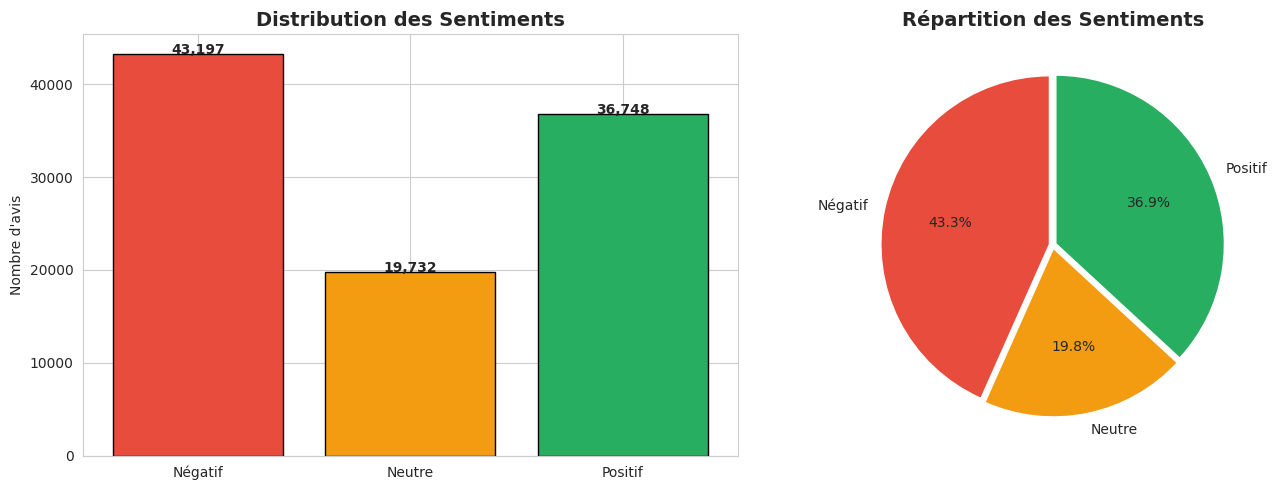

In [ ]:
# ============================================================
# VISUALISATION : DISTRIBUTION DES CLASSES
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = ['#e74c3c', '#f39c12', '#27ae60']

# Graphique 1 : Barplot
sentiment_counts = df['sentiment'].value_counts().sort_index()
axes[0].bar(CLASS_NAMES, sentiment_counts.values, color=colors, edgecolor='black')
axes[0].set_title('Distribution des Sentiments', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Nombre d\'avis')

# Ajout des valeurs sur les barres
for i, v in enumerate(sentiment_counts.values):
    axes[0].text(i, v + 50, f'{v:,}', ha='center', fontweight='bold')

# Graphique 2 : Pie chart
axes[1].pie(
    sentiment_counts.values,
    labels=CLASS_NAMES,
    autopct='%1.1f%%',
    colors=colors,
    explode=(0.02, 0.02, 0.02),
    startangle=90
)
axes[1].set_title('Répartition des Sentiments', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


### 📝 Interprétation - Distribution des Classes

**Imbalance des Classes :**

L'une des principales observations à faire est la forte imbalance des classes. La catégorie négatif représente presque la moitié des avis, tandis que les classes neutre et positif sont relativement sous-représentées. Cela peut poser un défi lors de la construction de modèles de classification, car le modèle pourrait être biaisé en faveur de la classe majoritaire (négatif). Pour équilibrer nous allons procéder à une pondération des classes dans les modèles de machine learning pour tenir compte de ce déséquilibre


## 3.2 Longueur des Textes


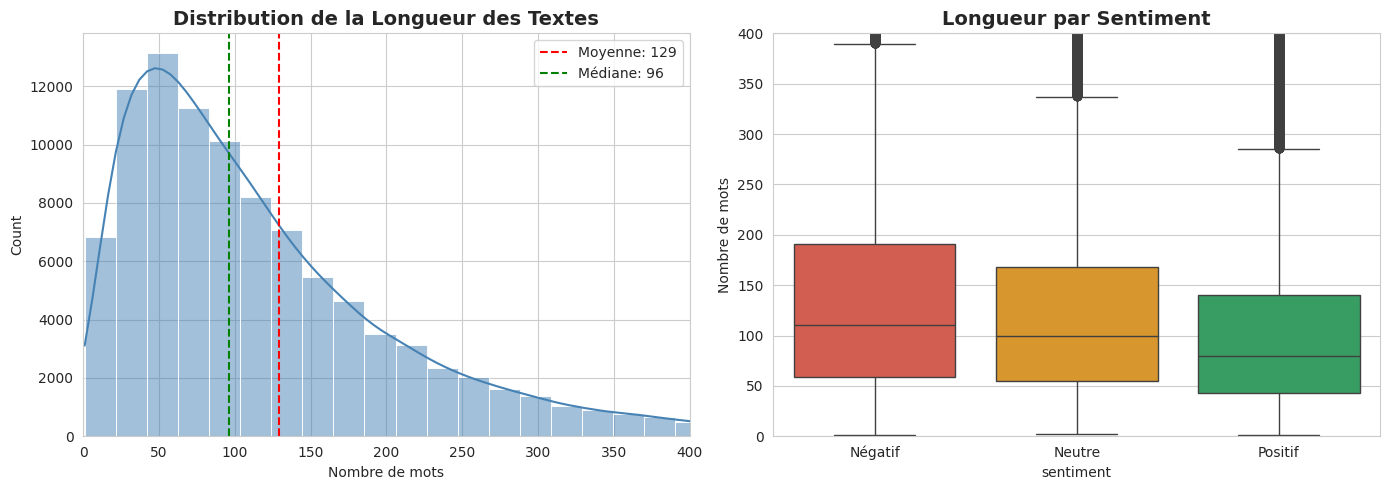

📊 Statistiques de longueur :
   Moyenne  : 129 mots
   Médiane  : 96 mots
   Maximum  : 1026 mots


In [ ]:
# ============================================================
# VISUALISATION : LONGUEUR DES TEXTES
# ============================================================

# Calcul de la longueur en mots
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1 : Distribution globale
sns.histplot(data=df, x='word_count', bins=50, kde=True, ax=axes[0], color='steelblue')
axes[0].axvline(df['word_count'].mean(), color='red', linestyle='--', label=f'Moyenne: {df["word_count"].mean():.0f}')
axes[0].axvline(df['word_count'].median(), color='green', linestyle='--', label=f'Médiane: {df["word_count"].median():.0f}')
axes[0].set_title('Distribution de la Longueur des Textes', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Nombre de mots')
axes[0].set_xlim(0, 400)
axes[0].legend()

# Graphique 2 : Par sentiment
sns.boxplot(data=df, x='sentiment', y='word_count', hue='sentiment', palette=colors, ax=axes[1], legend=False)
axes[1].set_xticklabels(CLASS_NAMES)
axes[1].set_title('Longueur par Sentiment', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Nombre de mots')
axes[1].set_ylim(0, 400)

plt.tight_layout()
plt.show()

# Statistiques
print(f"📊 Statistiques de longueur :")
print(f"   Moyenne  : {df['word_count'].mean():.0f} mots")
print(f"   Médiane  : {df['word_count'].median():.0f} mots")
print(f"   Maximum  : {df['word_count'].max()} mots")


### 📝 Interprétation - Longueur des Textes
Les avis négatifs sont plus détaillés et plus longs que les avis neutres ou positifs.

Les données sur la longueur des textes peuvent être utiles pour l'analyse de la tonalité des avis, les avis longs étant plus susceptibles de contenir des nuances émotionnelles importantes.


## 3.3 WordCloud par Sentiment


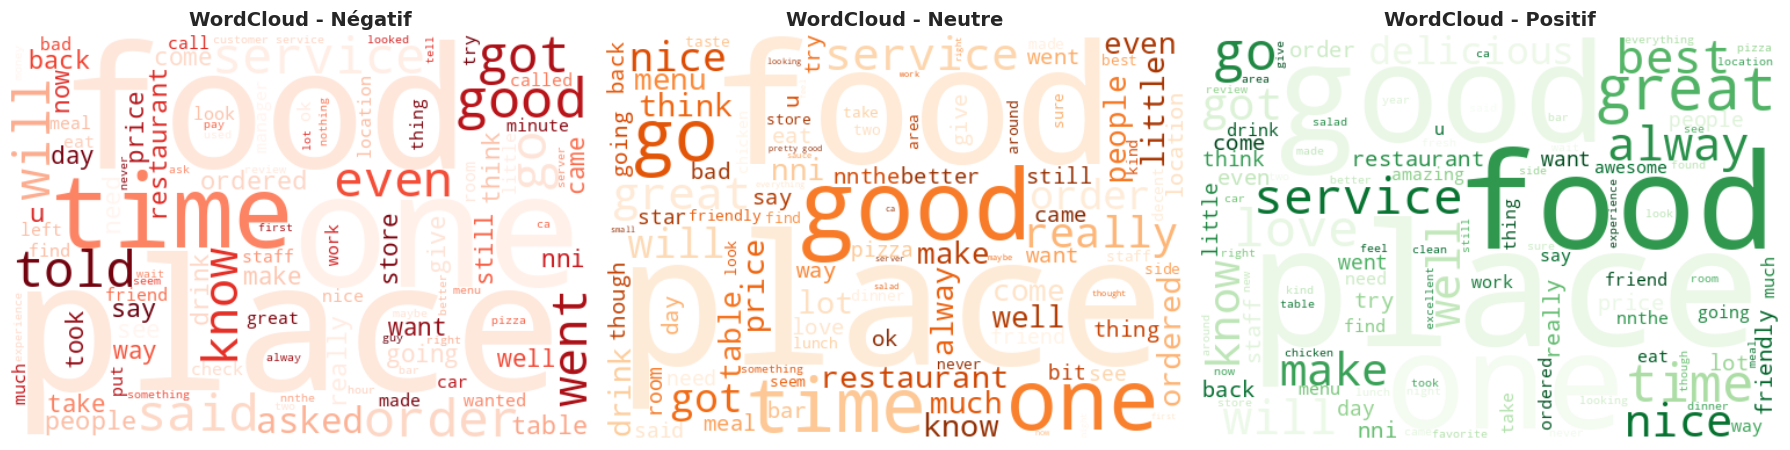

In [ ]:
# ============================================================
# VISUALISATION : WORDCLOUDS
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colormaps = ['Reds', 'Oranges', 'Greens']

for i, (name, cmap) in enumerate(zip(CLASS_NAMES, colormaps)):
    # Concaténation des textes de chaque classe
    text_corpus = ' '.join(df[df['sentiment'] == i]['clean_text'].tolist())

    # Génération du WordCloud
    wordcloud = WordCloud(
        width=500,
        height=350,
        background_color='white',
        colormap=cmap,
        max_words=100,
        random_state=SEED
    ).generate(text_corpus)

    # Affichage
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'WordCloud - {name}', fontsize=14, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


### 📝 Interprétation - WordClouds

Les nuages de mots montrent clairement les différences dans les types d'avis :

Les avis négatifs mettent l'accent sur des aspects problématiques comme le temps d'attente et le service.

Les avis neutres reflètent une satisfaction modérée, avec un accent sur des éléments comme la nourriture et le service, mais sans enthousiasme.

Les avis positifs sont principalement axés sur des expériences exceptionnelles et un excellent service.

Ces informations peuvent aider à mieux comprendre les points clés qui influencent les avis des clients et orienter des améliorations pour les avis négatifs.

## 3.4 Analyse des N-Grams (Bi-grams)


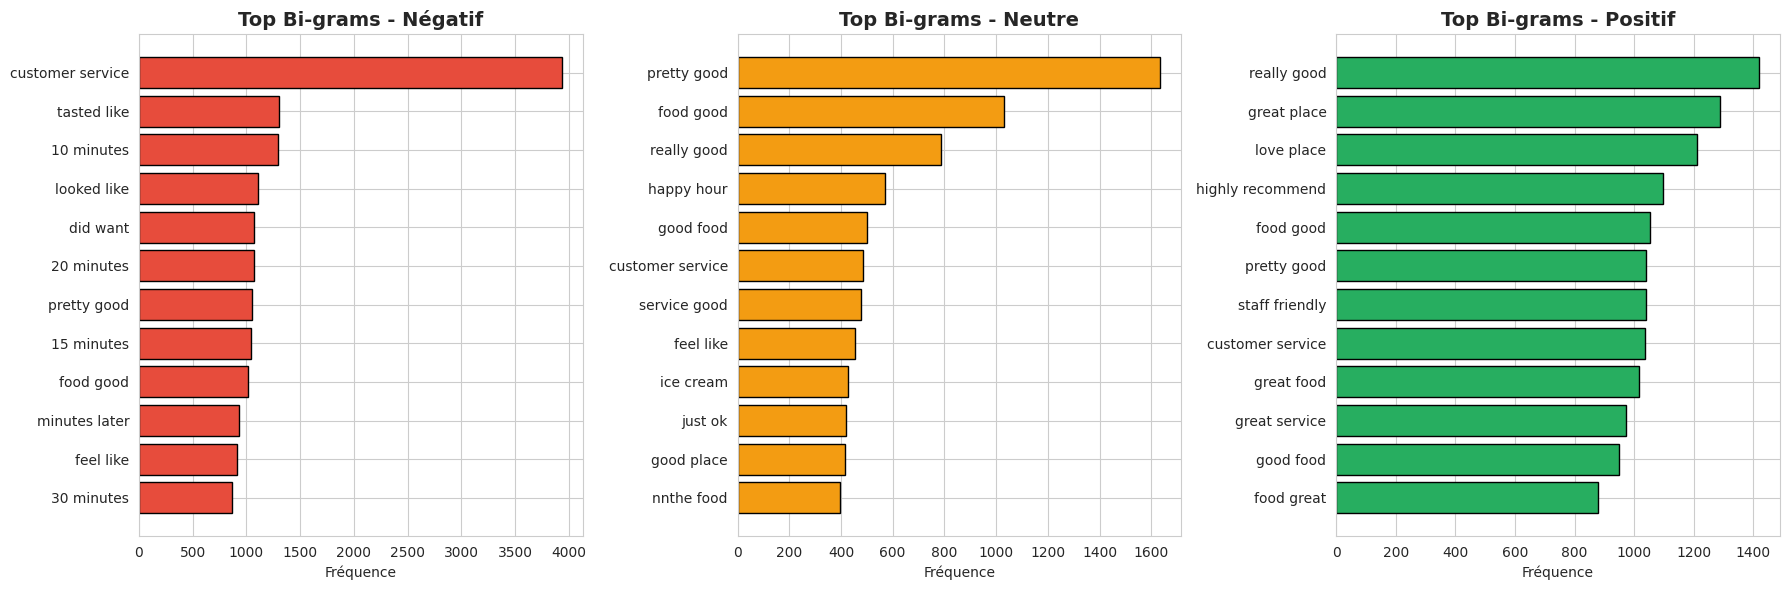

In [ ]:
# ============================================================
# VISUALISATION : TOP BI-GRAMS PAR SENTIMENT
# ============================================================

def get_top_ngrams(corpus, n=2, top_k=10):
    """Extrait les n-grams les plus fréquents d'un corpus."""
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    ngrams = vectorizer.fit_transform(corpus)

    # Somme des occurrences
    sum_ngrams = ngrams.sum(axis=0)
    ngram_freq = [(word, sum_ngrams[0, idx]) for word, idx in vectorizer.vocabulary_.items()]

    # Tri par fréquence
    return sorted(ngram_freq, key=lambda x: x[1], reverse=True)[:top_k]

# Création des graphiques
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, (name, color) in enumerate(zip(CLASS_NAMES, colors)):
    # Extraction des bi-grams pour cette classe
    corpus = df[df['sentiment'] == i]['clean_text'].tolist()
    top_bigrams = get_top_ngrams(corpus, n=2, top_k=12)

    # Préparation des données
    words, counts = zip(*top_bigrams)

    # Barplot horizontal
    axes[i].barh(words, counts, color=color, edgecolor='black')
    axes[i].set_title(f'Top Bi-grams - {name}', fontsize=14, fontweight='bold')
    axes[i].invert_yaxis()
    axes[i].set_xlabel('Fréquence')

plt.tight_layout()
plt.show()


### 📝 Interprétation - Bi-grams

***Les graphiques ci-dessus montrent les top 10 des bi-grams (paires de mots) les plus fréquents pour chaque sentiment : négatif, neutre, et positif.***

Négatif : Les critiques se concentrent sur des aspects liés au service et à la qualité de la nourriture, avec une insatisfaction notable sur l'attente et l'expérience générale.

Neutre : Les critiques sont modérées, avec des termes exprimant des opinions moyennes sur la nourriture et le service, sans enthousiasme.

Positif : Les critiques positives mettent en avant des aspects exceptionnels de l'expérience, notamment la qualité de la nourriture et un excellent service, souvent accompagnés d'une forte recommandation.



# 4️⃣ Modèle Baseline : TF-IDF + Régression Logistique


## 4.1 Vectorisation TF-IDF


In [ ]:
# ============================================================
# VECTORISATION TF-IDF
# ============================================================

print("📐 Vectorisation TF-IDF en cours...")

# Configuration du vectorizer
# - max_features : limite le vocabulaire aux 5000 termes les plus fréquents
# - ngram_range : inclut les bi-grams pour capturer le contexte local
# - stop_words : supprime les mots vides anglais

tfidf_vectorizer = TfidfVectorizer(
    max_features=8000,   ## 5000 avant
    ngram_range=(1, 2),
    stop_words='english',
    min_df=2  # Ignore les termes présents dans moins de 2 documents
)

# Fit sur le train, transform sur train et test
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"✅ Vectorisation terminée :")
print(f"   - Vocabulaire : {len(tfidf_vectorizer.get_feature_names_out()):,} termes")
print(f"   - Shape Train : {X_train_tfidf.shape}")
print(f"   - Shape Test  : {X_test_tfidf.shape}")


📐 Vectorisation TF-IDF en cours...
✅ Vectorisation terminée :
   - Vocabulaire : 8,000 termes
   - Shape Train : (79741, 8000)
   - Shape Test  : (19936, 8000)


## 4.2 Entraînement du Modèle


In [ ]:
# ============================================================
# ENTRAÎNEMENT - RÉGRESSION LOGISTIQUE
# ============================================================

print("🎯 Entraînement de la Régression Logistique...")

# Configuration du modèle
# - class_weight='balanced' : gère automatiquement le déséquilibre des classes
# - solver='lbfgs' : bon choix pour les datasets de taille moyenne
# - max_iter : nombre max d'itérations pour la convergence

baseline_model = LogisticRegression(
    max_iter=1000,
    random_state=SEED,
    class_weight='balanced',
    solver='lbfgs',
    n_jobs=-1  # Utilise tous les CPU
)

# Entraînement
baseline_model.fit(X_train_tfidf, y_train)

print("✅ Modèle Baseline entraîné.")


🎯 Entraînement de la Régression Logistique...
✅ Modèle Baseline entraîné.


## 4.3 Évaluation du Modèle Baseline


In [ ]:
# ============================================================
# ÉVALUATION - BASELINE
# ============================================================

# Prédictions
y_pred_baseline = baseline_model.predict(X_test_tfidf)
y_proba_baseline = baseline_model.predict_proba(X_test_tfidf)

# Métriques
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
baseline_f1_weighted = f1_score(y_test, y_pred_baseline, average='weighted')
baseline_f1_macro = f1_score(y_test, y_pred_baseline, average='macro')

print("=" * 60)
print("📊 RÉSULTATS - BASELINE (TF-IDF + Régression Logistique)")
print("=" * 60)
print(f"\n🎯 Accuracy       : {baseline_accuracy:.2%}")
print(f"🎯 F1 Weighted    : {baseline_f1_weighted:.2%}")
print(f"🎯 F1 Macro       : {baseline_f1_macro:.2%}")

print("\n📋 Rapport de Classification :")
print(classification_report(y_test, y_pred_baseline, target_names=CLASS_NAMES, digits=4))


📊 RÉSULTATS - BASELINE (TF-IDF + Régression Logistique)

🎯 Accuracy       : 74.59%
🎯 F1 Weighted    : 75.44%
🎯 F1 Macro       : 71.37%

📋 Rapport de Classification :
              precision    recall  f1-score   support

     Négatif     0.8651    0.7920    0.8269      8640
      Neutre     0.4602    0.5930    0.5182      3946
     Positif     0.8193    0.7737    0.7959      7350

    accuracy                         0.7459     19936
   macro avg     0.7149    0.7196    0.7137     19936
weighted avg     0.7681    0.7459    0.7544     19936



**Analyse**

Le modèle est particulièrement performant pour les classes négatif (précision de 86.51%) et positif (précision de 81.93%). Cependant, la classe neutre reste un défi avec une précision faible de 46.02%. Un ajustement sur la gestion des classes neutres pourrait améliorer les résultats globaux.

## 4.4 Matrice de Confusion - Baseline


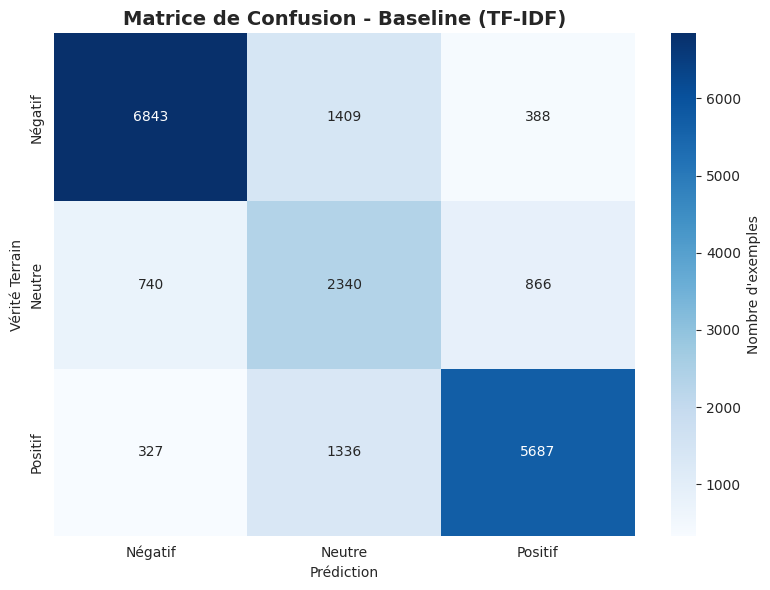

In [ ]:
# ============================================================
# MATRICE DE CONFUSION - BASELINE
# ============================================================

cm_baseline = confusion_matrix(y_test, y_pred_baseline)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_baseline,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES,
    cbar_kws={'label': 'Nombre d\'exemples'}
)
plt.title('Matrice de Confusion - Baseline (TF-IDF)', fontsize=14, fontweight='bold')
plt.xlabel('Prédiction')
plt.ylabel('Vérité Terrain')
plt.tight_layout()
plt.show()



**Analyse**

Le modèle est performant pour les avis négatifs avec un bon taux de vrais négatifs (6843) et des faux négatifs relativement faibles (388).

Pour la classe neutre, il y a un fort taux de faux positifs (2340), suggérant des difficultés dans l'identification des avis neutres.

La classe positive est correctement identifiée dans 5687 cas, mais il existe encore des erreurs de classification (1336 faux positifs).

## 4.5 Interprétabilité - Mots Importants


🔍 Analyse des mots les plus influents par classe :


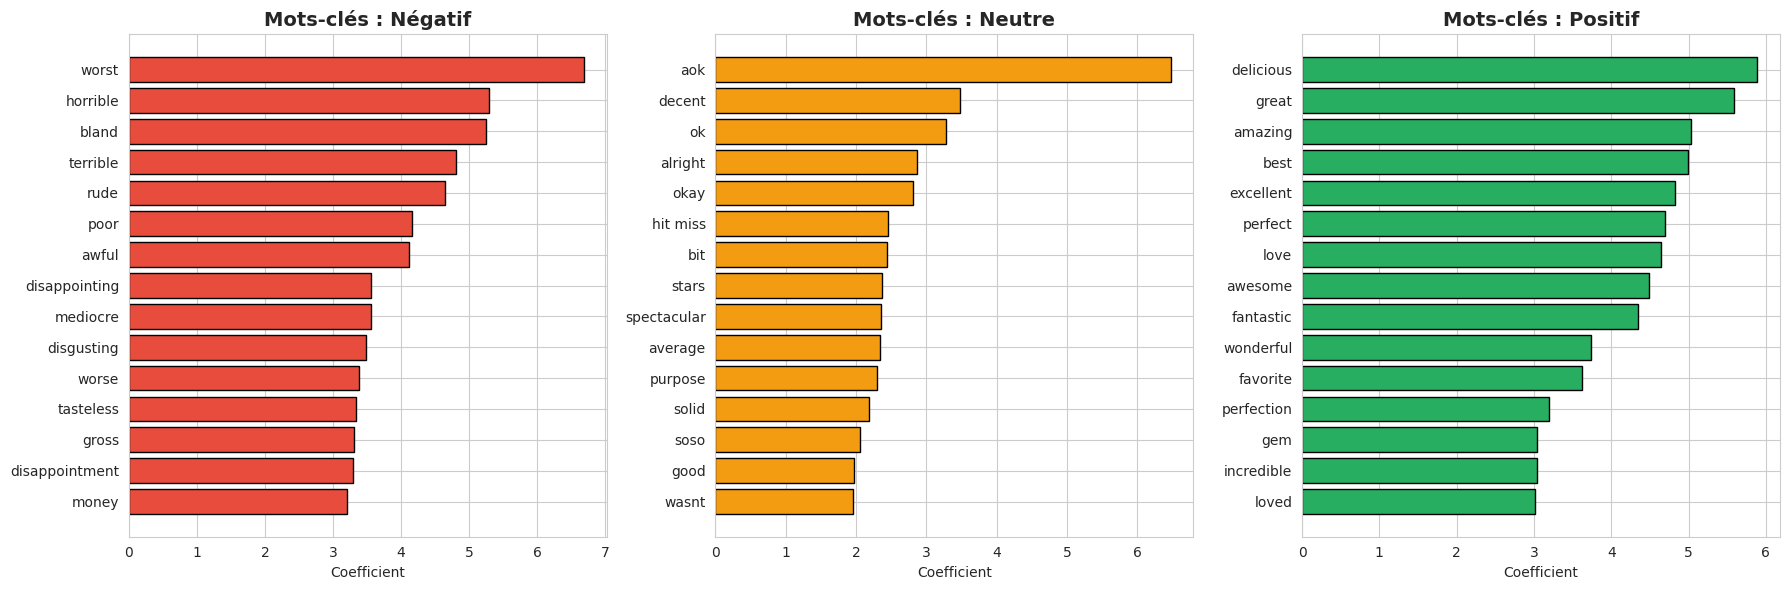

In [ ]:
# ============================================================
# INTERPRÉTABILITÉ - FEATURE IMPORTANCE
# ============================================================

def plot_feature_importance(model, vectorizer, class_names, top_k=15):
    """Affiche les mots les plus importants pour chaque classe."""

    feature_names = vectorizer.get_feature_names_out()

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    colors_gradient = ['#e74c3c', '#f39c12', '#27ae60']

    for i, (name, color) in enumerate(zip(class_names, colors_gradient)):
        # Coefficients pour cette classe
        coefs = model.coef_[i]

        # Top features (les plus positifs)
        top_indices = np.argsort(coefs)[-top_k:]
        top_features = [feature_names[j] for j in top_indices]
        top_coefs = coefs[top_indices]

        # Plot
        axes[i].barh(top_features, top_coefs, color=color, edgecolor='black')
        axes[i].set_title(f'Mots-clés : {name}', fontsize=14, fontweight='bold')
        axes[i].set_xlabel('Coefficient')

    plt.tight_layout()
    plt.show()

print("🔍 Analyse des mots les plus influents par classe :")
plot_feature_importance(baseline_model, tfidf_vectorizer, CLASS_NAMES)


### 📝 Interprétation - Baseline TF-IDF

**Négatif** : Les mots-clés comme "worst", "horrible", et "money" sont représentatifs des expériences très négatives, souvent liées à une mauvaise qualité ou un mauvais service.

**Neutre** : Les mots-clés comme "decent", "average", et "solid" indiquent que les avis neutres sont modérés, sans forte satisfaction ni critique.

**Positif** : Les mots-clés comme "delicious", "great", et "amazing" témoignent de fortes satisfactions et de recommandations positives.




# 5️⃣ Modèle Deep Learning : Fine-tuning DistilBERT


## 5.1 Tokenisation


In [ ]:
# ============================================================
# TOKENISATION DISTILBERT
# ============================================================

MODEL_CHECKPOINT = "distilbert-base-uncased"
MAX_LENGTH = 512  # Longueur max des séquences                  # 256 avant

print(f"📥 Chargement du tokenizer : {MODEL_CHECKPOINT}")
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_CHECKPOINT)

def tokenize_function(examples):
    """Tokenise les textes avec padding et troncature."""
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_LENGTH
    )

# Conversion en Dataset HuggingFace
train_dataset = Dataset.from_pandas(
    pd.DataFrame({'text': X_train, 'label': y_train})
)
test_dataset = Dataset.from_pandas(
    pd.DataFrame({'text': X_test, 'label': y_test})
)

# Tokenisation
print("🔄 Tokenisation en cours...")
encoded_train = train_dataset.map(tokenize_function, batched=True, remove_columns=['text'])
encoded_test = test_dataset.map(tokenize_function, batched=True, remove_columns=['text'])

print(f"✅ Tokenisation terminée.")
print(f"   - Train : {len(encoded_train):,} exemples")
print(f"   - Test  : {len(encoded_test):,} exemples")


📥 Chargement du tokenizer : distilbert-base-uncased
🔄 Tokenisation en cours...


Map:   0%|          | 0/79741 [00:00<?, ? examples/s]

Map:   0%|          | 0/19936 [00:00<?, ? examples/s]

✅ Tokenisation terminée.
   - Train : 79,741 exemples
   - Test  : 19,936 exemples


## 5.2 Configuration du Modèle


In [ ]:
# ============================================================
# CONFIGURATION MODÈLE DISTILBERT
# ============================================================

# Calcul des poids de classes pour gérer le déséquilibre
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Ajustement des poids (éviter les extrêmes)
class_weights = np.clip(class_weights, 0.5, 2.0)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)

print(f"⚖️  Poids des classes : {dict(zip(CLASS_NAMES, class_weights.round(2)))}")

# Configuration personnalisée avec dropout augmenté
config = DistilBertConfig.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=3,
    id2label={0: "NEG", 1: "NEU", 2: "POS"},
    label2id={"NEG": 0, "NEU": 1, "POS": 2},
    dropout=0.2,
    attention_dropout=0.2
)

# Chargement du modèle
bert_model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_CHECKPOINT,
    config=config
).to(DEVICE)

print(f"✅ Modèle chargé sur {DEVICE}")


⚖️  Poids des classes : {'Négatif': np.float64(0.77), 'Neutre': np.float64(1.68), 'Positif': np.float64(0.9)}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Modèle chargé sur cuda


## 5.3 Custom Trainer avec Poids de Classes


In [ ]:
# ============================================================
# CUSTOM TRAINER AVEC POIDS DE CLASSES
# ============================================================

class WeightedTrainer(Trainer):
    """Trainer personnalisé avec CrossEntropy pondérée."""

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # CrossEntropy avec poids de classes
        loss_fn = nn.CrossEntropyLoss(weight=weights_tensor)
        loss = loss_fn(logits.view(-1, model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

# Fonction de métriques
def compute_metrics(eval_pred):
    """Calcule les métriques d'évaluation."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1_weighted": f1_score(labels, predictions, average='weighted'),
        "f1_macro": f1_score(labels, predictions, average='macro'),
        "kappa": cohen_kappa_score(labels, predictions)
    }

print("✅ Custom Trainer défini.")


✅ Custom Trainer défini.


## Analyse de la démarche utilisée
1. Calcul des Poids de Classes :

Pour gérer le déséquilibre des classes, les poids de classes ont été calculés de manière équilibrée à l'aide de compute_class_weight :

Poids des classes :

Négatif : 0.77

Neutre : 1.68

Positif : 0.90

Les poids de classes ont ensuite été ajustés pour éviter des extrêmes, ce qui permet de mieux gérer l'impact des classes sous-représentées et sur-représentées dans le modèle.

2. Personnalisation de l'Entraînement (WeightedTrainer) :

Un custom trainer a été défini pour utiliser une CrossEntropyLoss pondérée en fonction des poids de classes calculés précédemment. Cette pondération permet de compenser l'imbalance des classes pendant l'entraînement, en accordant plus d'importance aux classes sous-représentées.

CrossEntropyLoss avec poids de classes : Utilisation de weights_tensor pour appliquer les poids de classes à la fonction de perte.

3. En Résumé :

Poids de classes : Ajustés pour améliorer la gestion de l'imbalance des classes.

Modèle DistilBERT : Configuré et chargé avec une attention au dropout pour éviter le sur-apprentissage.

Custom Trainer : Permet d'utiliser une fonction de perte pondérée pour l'entraînement avec des classes déséquilibrées.

Métriques d'évaluation : Un ensemble complet de métriques pour évaluer la performance du modèle.

## 5.4 Configuration de l'Entraînement


In [ ]:
# ============================================================
# CONFIGURATION ENTRAÎNEMENT
# ============================================================

OUTPUT_DIR = "./distilbert-sentiment"     # Chemin où seront sauvegardés les modèles entraînés

training_args = TrainingArguments(         # Création de l'objet contenant tous les paramètres d'entraînement
    output_dir=OUTPUT_DIR,                 # Dossier de sortie des checkpoints

    # --------- ÉVALUATION ----------
    eval_strategy="steps",                 # Évalue le modèle tous les X steps
    eval_steps=200,                        # Nombre de steps entre chaque évaluation

    # --------- SAUVEGARDE ----------
    save_strategy="steps",                 # Sauvegarde le modèle tous les X steps
    save_steps=200,                        # Nombre de steps entre chaque sauvegarde
    save_total_limit=2,                    # Maximum de checkpoints conservés (pour éviter d'encombrer le disque)

    # --------- HYPERPARAMÈTRES ----------
    learning_rate=2e-5,                    # Taux d’apprentissage
    per_device_train_batch_size=32,        # Taille du batch pour l’entraînement
    per_device_eval_batch_size=32,         # Taille du batch pour l’évaluation
    num_train_epochs=3,                    # Nombre total d'époques d'entraînement
    weight_decay=0.01,                     # Régularisation L2 pour éviter le surapprentissage
    warmup_steps=100,                      # Nombre de steps "warmup" pour stabiliser le début de l'entraînement

    # --------- OPTIMISATIONS ----------
    fp16=torch.cuda.is_available(),        # Active le float16 (plus rapide) si une GPU CUDA est dispo
    dataloader_num_workers=2,              # Nombre de workers pour charger les données en parallèle

    # --------- LOGGING ----------
    logging_steps=100,                     # Fréquence d'affichage des logs durant l’entraînement
    report_to="none",                      # Désactive l'envoi vers wandb ou tensorboard

    # --------- MEILLEUR MODÈLE ----------
    load_best_model_at_end=True,           # Recharge le meilleur modèle (selon la métrique choisie) en fin d'entraînement
    metric_for_best_model="eval_loss",     # La métrique utilisée pour choisir le meilleur modèle
    greater_is_better=False,               # Plus petit = meilleur (car on minimise la loss)
)

# --------- INITIALISATION DU TRAINER ----------
trainer = WeightedTrainer(
    model=bert_model,                       # Le modèle DistilBERT déjà configuré
    args=training_args,                     # Les paramètres d'entraînement définis au-dessus
    train_dataset=encoded_train,            # Dataset tokenisé pour l’entraînement
    eval_dataset=encoded_test,              # Dataset tokenisé pour l’évaluation
    tokenizer=tokenizer,                    # Tokenizer pour le preprocessing
    compute_metrics=compute_metrics,        # Fonction pour calculer accuracy, F1, kappa...
    callbacks=[                             # Liste des callbacks
        EarlyStoppingCallback(early_stopping_patience=2)  # Stoppe l’entraînement si la perf n'améliore plus
    ]
)

# Affichage de quelques infos récapitulatives
print("✅ Trainer configuré.")
print(f"   - Epochs : {training_args.num_train_epochs}")
print(f"   - Batch size : {training_args.per_device_train_batch_size}")
print(f"   - Learning rate : {training_args.learning_rate}")


✅ Trainer configuré.
   - Epochs : 3
   - Batch size : 32
   - Learning rate : 2e-05


## 5.5 Entraînement


In [ ]:
# ============================================================
# ENTRAÎNEMENT DISTILBERT
# ============================================================

print("🚀 Démarrage de l'entraînement DistilBERT...")
print("=" * 60)

# Lancement
train_result = trainer.train()

print("=" * 60)
print("✅ Entraînement terminé.")
print(f"   - Temps total : {train_result.metrics['train_runtime']:.0f} secondes")


🚀 Démarrage de l'entraînement DistilBERT...


Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro,Kappa
200,0.683000,0.638412,0.765399,0.762986,0.713053,0.631617
400,0.616500,0.602393,0.781451,0.782241,0.735982,0.656811
600,0.599200,0.575505,0.752307,0.770498,0.732274,0.626951
800,0.591500,0.549001,0.777990,0.788522,0.749346,0.660318
1000,0.572700,0.546784,0.788022,0.795056,0.753493,0.672917
1200,0.559600,0.549477,0.797502,0.800204,0.757856,0.684678
1400,0.554300,0.535295,0.802970,0.807428,0.766854,0.693455
1600,0.521400,0.529585,0.791533,0.800725,0.762341,0.680265
1800,0.533400,0.535236,0.802368,0.806399,0.765630,0.692950
2000,0.546800,0.523311,0.793890,0.802803,0.763441,0.682527


✅ Entraînement terminé.
   - Temps total : 2935 secondes


## 5.6 Évaluation du Modèle BERT


In [ ]:
# ============================================================
# ÉVALUATION - DISTILBERT
# ============================================================

# Prédictions
print("🔮 Génération des prédictions...")
predictions_output = trainer.predict(encoded_test)

# Extraction des résultats
logits = predictions_output.predictions
y_proba_bert = torch.softmax(torch.tensor(logits), dim=-1).numpy()
y_pred_bert = np.argmax(y_proba_bert, axis=1)

# Métriques
bert_accuracy = accuracy_score(y_test, y_pred_bert)
bert_f1_weighted = f1_score(y_test, y_pred_bert, average='weighted')
bert_f1_macro = f1_score(y_test, y_pred_bert, average='macro')

print("\n" + "=" * 60)
print("📊 RÉSULTATS - DistilBERT")
print("=" * 60)
print(f"\n🎯 Accuracy       : {bert_accuracy:.2%}")
print(f"🎯 F1 Weighted    : {bert_f1_weighted:.2%}")
print(f"🎯 F1 Macro       : {bert_f1_macro:.2%}")

print("\n📋 Rapport de Classification :")
print(classification_report(y_test, y_pred_bert, target_names=CLASS_NAMES, digits=4))


🔮 Génération des prédictions...



📊 RÉSULTATS - DistilBERT

🎯 Accuracy       : 80.53%
🎯 F1 Weighted    : 81.31%
🎯 F1 Macro       : 77.49%

📋 Rapport de Classification :
              precision    recall  f1-score   support

     Négatif     0.9109    0.8447    0.8765      8640
      Neutre     0.5250    0.6723    0.5896      3946
     Positif     0.8884    0.8305    0.8584      7350

    accuracy                         0.8053     19936
   macro avg     0.7748    0.7825    0.7749     19936
weighted avg     0.8262    0.8053    0.8131     19936



**Analyse**

Le modèle DistilBERT est très performant pour la classe négative (précision de 91.09%) et pour la classe positive (précision de 88.84%).

Cependant, il présente des difficultés pour la classe neutre (précision de 52.50%), ce qui suggère qu'une amélioration est nécessaire pour mieux identifier les avis neutres.

Les moyennes pondérées montrent que le modèle gère bien l'imbalance des classes, avec un score F1 Weighted de 81.31%.

## 5.7 Matrice de Confusion - BERT


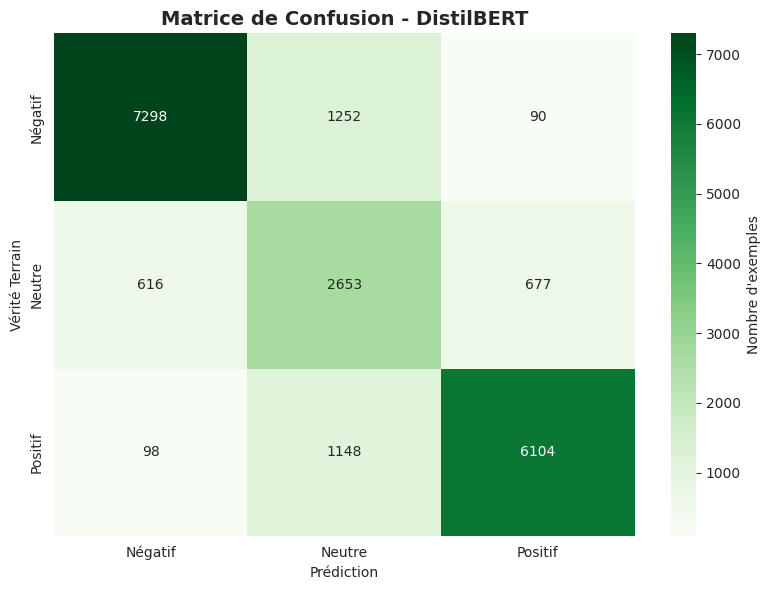

In [ ]:
# ============================================================
# MATRICE DE CONFUSION - BERT
# ============================================================

cm_bert = confusion_matrix(y_test, y_pred_bert)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_bert,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES,
    cbar_kws={'label': 'Nombre d\'exemples'}
)
plt.title('Matrice de Confusion - DistilBERT', fontsize=14, fontweight='bold')
plt.xlabel('Prédiction')
plt.ylabel('Vérité Terrain')
plt.tight_layout()
plt.show()


### 📝 Interprétation - DistilBERT
Le modèle DistilBERT est très efficace pour la classe négative avec un grand nombre de vrais négatifs (7298).

Cependant, il a des difficultés avec la classe neutre, où il confond beaucoup d'avis avec les classes négative et positive (2653 faux positifs).

La classe positive est bien identifiée, mais 1148 faux positifs suggèrent des erreurs occasionnelles dans la prédiction.

---
# 6️⃣ Comparaison des Modèles


## 6.1 Tableau Comparatif


In [ ]:
# ============================================================
# TABLEAU COMPARATIF
# ============================================================

# F1 par classe - Baseline
f1_baseline_per_class = f1_score(y_test, y_pred_baseline, average=None)

# F1 par classe - BERT
f1_bert_per_class = f1_score(y_test, y_pred_bert, average=None)

# Construction du tableau
comparison_data = {
    'Métrique': [
        'Accuracy',
        'F1 Weighted',
        'F1 Macro',
        f'F1 {CLASS_NAMES[0]}',
        f'F1 {CLASS_NAMES[1]}',
        f'F1 {CLASS_NAMES[2]}'
    ],
    'TF-IDF + LogReg': [
        baseline_accuracy,
        baseline_f1_weighted,
        baseline_f1_macro,
        f1_baseline_per_class[0],
        f1_baseline_per_class[1],
        f1_baseline_per_class[2]
    ],
    'DistilBERT': [
        bert_accuracy,
        bert_f1_weighted,
        bert_f1_macro,
        f1_bert_per_class[0],
        f1_bert_per_class[1],
        f1_bert_per_class[2]
    ]
}

comparison_df = pd.DataFrame(comparison_data)

# Calcul de l'amélioration
comparison_df['Δ Absolu'] = comparison_df['DistilBERT'] - comparison_df['TF-IDF + LogReg']
comparison_df['Δ Relatif (%)'] = (
    (comparison_df['DistilBERT'] - comparison_df['TF-IDF + LogReg'])
    / comparison_df['TF-IDF + LogReg'] * 100
).round(1)

# Formatage pour affichage
comparison_display = comparison_df.copy()
comparison_display['TF-IDF + LogReg'] = comparison_display['TF-IDF + LogReg'].apply(lambda x: f"{x:.2%}")
comparison_display['DistilBERT'] = comparison_display['DistilBERT'].apply(lambda x: f"{x:.2%}")
comparison_display['Δ Absolu'] = comparison_display['Δ Absolu'].apply(lambda x: f"{x:+.2%}")
comparison_display['Δ Relatif (%)'] = comparison_display['Δ Relatif (%)'].apply(lambda x: f"{x:+.1f}%")

print("=" * 80)
print("📊 COMPARAISON DES MODÈLES")
print("=" * 80)
display(comparison_display)


📊 COMPARAISON DES MODÈLES


,Métrique,TF-IDF + LogReg,DistilBERT,Δ Absolu,Δ Relatif (%)
0,Accuracy,74.59%,80.53%,+5.94%,+8.0%
1,F1 Weighted,75.44%,81.31%,+5.87%,+7.8%
2,F1 Macro,71.37%,77.49%,+6.12%,+8.6%
3,F1 Négatif,82.69%,87.65%,+4.96%,+6.0%
4,F1 Neutre,51.82%,58.96%,+7.14%,+13.8%
5,F1 Positif,79.59%,85.84%,+6.26%,+7.9%


**Analyse**

Le modèle DistilBERT montre des améliorations significatives par rapport à TF-IDF + LogReg :

Augmentation de la précision générale (Accuracy +5.94%).

Amélioration des scores F1 pour toutes les classes, avec des gains notables pour les classes négative (+4.96%) et neutre (+7.14%).

DistilBERT surpasse TF-IDF + LogReg dans toutes les métriques importantes, ce qui prouve sa capacité à mieux capturer les subtilités des sentiments dans les avis.

Cela montre que DistilBERT est bien plus adapté pour la tâche de classification des sentiments, notamment pour les classes neutre et positive.

## 6.2 Visualisation Comparative


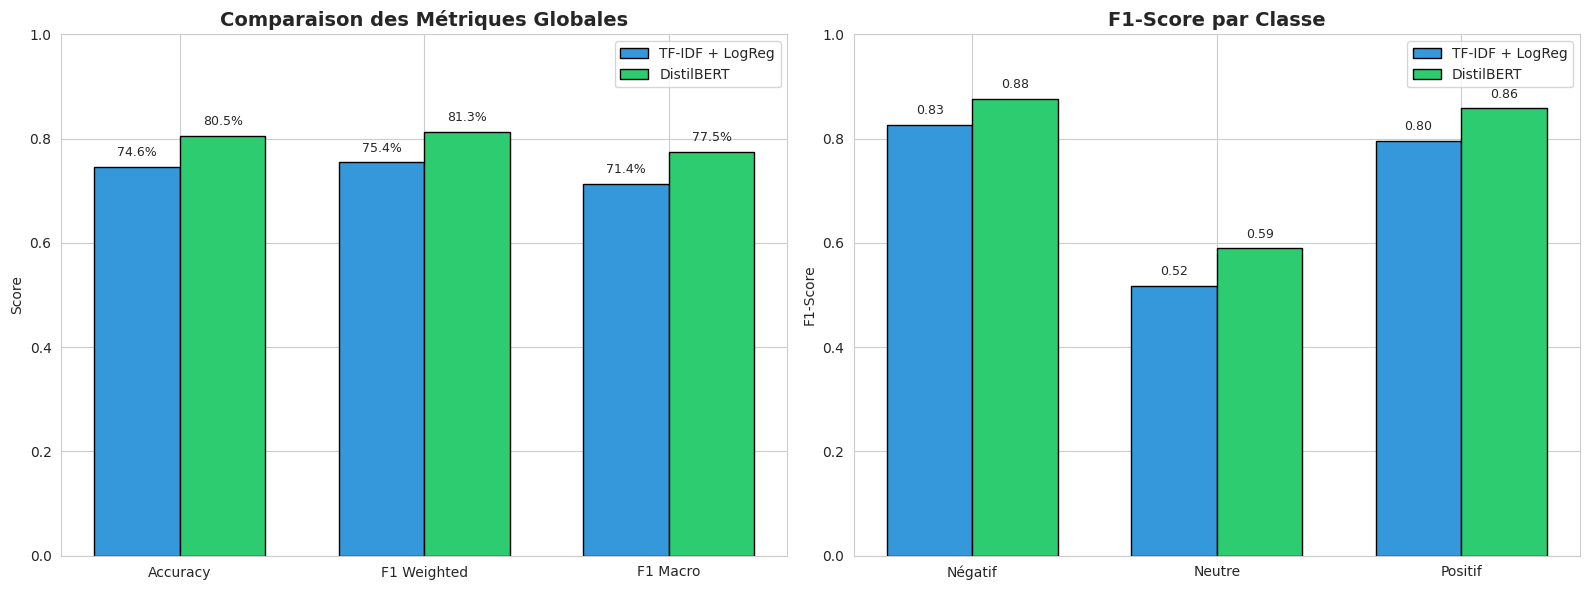

In [ ]:
# ============================================================
# GRAPHIQUES COMPARATIFS
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Données pour les graphiques
metrics_names = ['Accuracy', 'F1 Weighted', 'F1 Macro']
baseline_scores = [baseline_accuracy, baseline_f1_weighted, baseline_f1_macro]
bert_scores = [bert_accuracy, bert_f1_weighted, bert_f1_macro]

# Graphique 1 : Métriques globales
x = np.arange(len(metrics_names))
width = 0.35

bars1 = axes[0].bar(x - width/2, baseline_scores, width, label='TF-IDF + LogReg', color='#3498db', edgecolor='black')
bars2 = axes[0].bar(x + width/2, bert_scores, width, label='DistilBERT', color='#2ecc71', edgecolor='black')

axes[0].set_ylabel('Score')
axes[0].set_title('Comparaison des Métriques Globales', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_names)
axes[0].legend()
axes[0].set_ylim(0, 1)

# Ajout des valeurs
for bar in bars1:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{bar.get_height():.1%}', ha='center', fontsize=9)
for bar in bars2:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{bar.get_height():.1%}', ha='center', fontsize=9)

# Graphique 2 : F1 par classe
x = np.arange(len(CLASS_NAMES))

bars1 = axes[1].bar(x - width/2, f1_baseline_per_class, width, label='TF-IDF + LogReg', color='#3498db', edgecolor='black')
bars2 = axes[1].bar(x + width/2, f1_bert_per_class, width, label='DistilBERT', color='#2ecc71', edgecolor='black')

axes[1].set_ylabel('F1-Score')
axes[1].set_title('F1-Score par Classe', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(CLASS_NAMES)
axes[1].legend()
axes[1].set_ylim(0, 1)

# Ajout des valeurs
for bar in bars1:
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{bar.get_height():.2f}', ha='center', fontsize=9)
for bar in bars2:
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{bar.get_height():.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()


**Analyse**

DistilBERT surpasse TF-IDF + LogReg dans toutes les métriques, avec des améliorations significatives en accuracy (+5.94%) et en F1-score pour toutes les classes.

Le modèle DistilBERT est particulièrement performant pour la classe Négatif et Positif, avec des gains de +0.05 et +0.06 en F1-score, respectivement.

Pour la classe Neutre, DistilBERT améliore également le modèle de +0.07, réduisant les confusions avec les autres classes.

DistilBERT montre une meilleure capacité à gérer les nuances dans les classes de sentiments, en particulier avec l'imbalance des classes.

## 6.3 Matrices de Confusion Côte à Côte


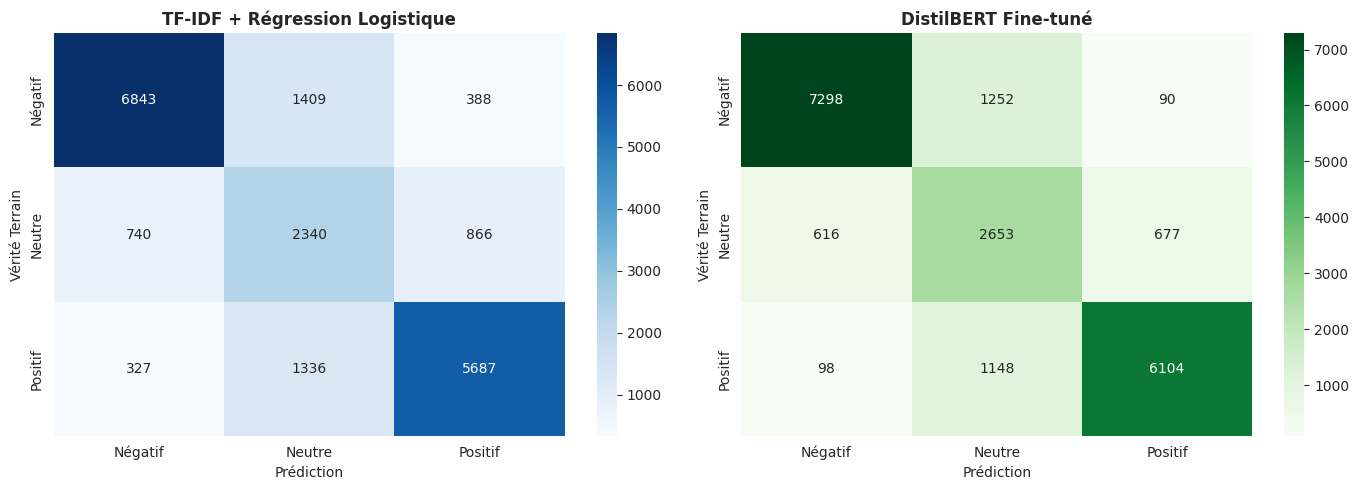

In [ ]:
# ============================================================
# MATRICES DE CONFUSION COMPARÉES
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Baseline
sns.heatmap(
    cm_baseline,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES,
    ax=axes[0]
)
axes[0].set_title('TF-IDF + Régression Logistique', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Prédiction')
axes[0].set_ylabel('Vérité Terrain')

# BERT
sns.heatmap(
    cm_bert,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES,
    ax=axes[1]
)
axes[1].set_title('DistilBERT Fine-tuné', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Prédiction')
axes[1].set_ylabel('Vérité Terrain')

plt.tight_layout()
plt.show()


### 📝 Interprétation - Comparaison des Modèles

DistilBERT surpasse largement TF-IDF + LogReg, avec des meilleures performances globales, une réduction significative des faux positifs et une meilleure gestion des classes.

En particulier, le modèle fine-tuné DistilBERT fait un excellent travail dans la classification des avis négatifs et positifs, avec des performances améliorées sur la classe neutre.


# 7️⃣ Analyse des Erreurs


In [ ]:
# ============================================================
# ANALYSE DES ERREURS
# ============================================================

# Création du DataFrame d'analyse
error_analysis = pd.DataFrame({
    'texte': X_test,
    'vrai_label': y_test,
    'pred_baseline': y_pred_baseline,
    'pred_bert': y_pred_bert,
    'proba_bert_neg': y_proba_bert[:, 0],
    'proba_bert_neu': y_proba_bert[:, 1],
    'proba_bert_pos': y_proba_bert[:, 2]
})

# Identification des erreurs
error_analysis['erreur_baseline'] = error_analysis['vrai_label'] != error_analysis['pred_baseline']
error_analysis['erreur_bert'] = error_analysis['vrai_label'] != error_analysis['pred_bert']

# Cas où BERT corrige Baseline
error_analysis['bert_corrige'] = error_analysis['erreur_baseline'] & ~error_analysis['erreur_bert']

# Statistiques
print("=" * 60)
print("📊 ANALYSE DES ERREURS")
print("=" * 60)
print(f"\n❌ Erreurs Baseline : {error_analysis['erreur_baseline'].sum():,} ({error_analysis['erreur_baseline'].mean():.1%})")
print(f"❌ Erreurs BERT     : {error_analysis['erreur_bert'].sum():,} ({error_analysis['erreur_bert'].mean():.1%})")
print(f"\n✅ Cas où BERT corrige Baseline : {error_analysis['bert_corrige'].sum():,}")


📊 ANALYSE DES ERREURS

❌ Erreurs Baseline : 5,066 (25.4%)
❌ Erreurs BERT     : 3,881 (19.5%)

✅ Cas où BERT corrige Baseline : 2,471


In [ ]:
# ============================================================
# ANALYSE DES ERREURS
# ============================================================

# Création du DataFrame d'analyse
error_analysis = pd.DataFrame({
    'texte': X_test,
    'vrai_label': y_test,
    'pred_baseline': y_pred_baseline,
    'pred_bert': y_pred_bert,
    'proba_bert_neg': y_proba_bert[:, 0],
    'proba_bert_neu': y_proba_bert[:, 1],
    'proba_bert_pos': y_proba_bert[:, 2]
})

# Identification des erreurs
error_analysis['erreur_baseline'] = error_analysis['vrai_label'] != error_analysis['pred_baseline']
error_analysis['erreur_bert'] = error_analysis['vrai_label'] != error_analysis['pred_bert']

# Cas où BERT corrige Baseline
error_analysis['bert_corrige'] = error_analysis['erreur_baseline'] & ~error_analysis['erreur_bert']

# Statistiques
print("=" * 60)
print("📊 ANALYSE DES ERREURS")
print("=" * 60)
print(f"\n❌ Erreurs Baseline : {error_analysis['erreur_baseline'].sum():,} ({error_analysis['erreur_baseline'].mean():.1%})")
print(f"❌ Erreurs BERT     : {error_analysis['erreur_bert'].sum():,} ({error_analysis['erreur_bert'].mean():.1%})")
print(f"\n✅ Cas où BERT corrige Baseline : {error_analysis['bert_corrige'].sum():,}")


📊 ANALYSE DES ERREURS

❌ Erreurs Baseline : 5,066 (25.4%)
❌ Erreurs BERT     : 3,881 (19.5%)

✅ Cas où BERT corrige Baseline : 2,471


In [ ]:
# ============================================================
# EXEMPLES D'ERREURS
# ============================================================

print("\n" + "=" * 60)
print("📝 EXEMPLES OÙ BERT CORRIGE BASELINE")
print("=" * 60)

bert_corrections = error_analysis[error_analysis['bert_corrige']].head(3)

for idx, row in bert_corrections.iterrows():
    print(f"\n📄 Texte : {row['texte'][:150]}...")
    print(f"   ✅ Vrai label    : {CLASS_NAMES[row['vrai_label']]}")
    print(f"   ❌ Pred Baseline : {CLASS_NAMES[row['pred_baseline']]}")
    print(f"   ✅ Pred BERT     : {CLASS_NAMES[row['pred_bert']]}")
    print(f"   📊 Confiance BERT: Neg={row['proba_bert_neg']:.1%}, Neu={row['proba_bert_neu']:.1%}, Pos={row['proba_bert_pos']:.1%}")



📝 EXEMPLES OÙ BERT CORRIGE BASELINE

📄 Texte : seriously? are these smoothies made with some prized tibetan yak enzyme or something? what on earth justifies a smoothie costing 8.99??nneven the smoo...
   ✅ Vrai label    : Négatif
   ❌ Pred Baseline : Neutre
   ✅ Pred BERT     : Négatif
   📊 Confiance BERT: Neg=95.3%, Neu=4.3%, Pos=0.4%

📄 Texte : horrible. this used to be a great place to grab some great breakfast and coffee, and despite it always being busy, the lines moved very quick and effi...
   ✅ Vrai label    : Négatif
   ❌ Pred Baseline : Neutre
   ✅ Pred BERT     : Négatif
   📊 Confiance BERT: Neg=96.5%, Neu=3.4%, Pos=0.1%

📄 Texte : had a good experience with a purchase in january, but since learned we were given incomplete information regarding the purchase. i went to the store a...
   ✅ Vrai label    : Neutre
   ❌ Pred Baseline : Négatif
   ✅ Pred BERT     : Neutre
   📊 Confiance BERT: Neg=20.5%, Neu=63.7%, Pos=15.8%


### 📝 Interprétation - Analyse des Erreurs

Ces exemples montrent que DistilBERT est beaucoup plus précis dans l'identification des sentiments, même lorsque le modèle baseline (TF-IDF + LogReg) fait des erreurs. BERT a non seulement corrigé les erreurs de classification, mais il a aussi montré une très haute confiance dans ses prédictions, surtout pour les avis négatifs.


---
# 8️⃣ Démonstration : Prédiction sur Nouveaux Textes


In [ ]:
# ============================================================
# FONCTION DE PRÉDICTION
# ============================================================

def predict_sentiment(text, model_type='bert'):
    """
    Prédit le sentiment d'un texte avec le modèle choisi.

    Args:
        text: Le texte à analyser
        model_type: 'baseline' ou 'bert'

    Returns:
        dict avec la prédiction et les probabilités
    """
    # Nettoyage
    clean = clean_text(text)

    if model_type == 'baseline':
        # TF-IDF + LogReg
        vec = tfidf_vectorizer.transform([clean])
        pred = baseline_model.predict(vec)[0]
        proba = baseline_model.predict_proba(vec)[0]
    else:
        # DistilBERT
        inputs = tokenizer(
            clean,
            return_tensors="pt",
            truncation=True,
            max_length=MAX_LENGTH
        ).to(DEVICE)

        with torch.no_grad():
            outputs = bert_model(**inputs)

        proba = torch.softmax(outputs.logits, dim=-1).cpu().numpy()[0]
        pred = np.argmax(proba)

    # Emojis
    emoji_map = {0: '🔴', 1: '🟡', 2: '🟢'}

    return {
        'texte': text[:100] + '...' if len(text) > 100 else text,
        'sentiment': f"{emoji_map[pred]} {CLASS_NAMES[pred]}",
        'confiance': f"{proba[pred]:.1%}",
        'probas': {CLASS_NAMES[i]: f"{proba[i]:.1%}" for i in range(3)}
    }


In [ ]:
# ============================================================
# DÉMONSTRATION
# ============================================================

# Exemples de test
test_examples = [
    "This restaurant was absolutely amazing! Best food I've ever had. Will definitely come back!",
    "The food was okay, nothing special but not bad either. Average experience.",
    "Terrible experience. Waited 2 hours for cold food. Never coming back!",
    "It was good but a bit expensive for what you get. Not sure if I'd recommend it.",
    "The service was great but the food was disappointing. Mixed feelings overall."
]

print("=" * 70)
print("🎯 DÉMONSTRATION - PRÉDICTION DE SENTIMENTS")
print("=" * 70)

for text in test_examples:
    print("\n" + "-" * 70)

    # Prédiction BERT
    result = predict_sentiment(text, model_type='bert')

    print(f"📝 Texte : {result['texte']}")
    print(f"🎯 Sentiment : {result['sentiment']} (Confiance: {result['confiance']})")
    print(f"📊 Probabilités : {result['probas']}")


🎯 DÉMONSTRATION - PRÉDICTION DE SENTIMENTS

----------------------------------------------------------------------
📝 Texte : This restaurant was absolutely amazing! Best food I've ever had. Will definitely come back!
🎯 Sentiment : 🟢 Positif (Confiance: 99.3%)
📊 Probabilités : {'Négatif': '0.1%', 'Neutre': '0.6%', 'Positif': '99.3%'}

----------------------------------------------------------------------
📝 Texte : The food was okay, nothing special but not bad either. Average experience.
🎯 Sentiment : 🟡 Neutre (Confiance: 82.6%)
📊 Probabilités : {'Négatif': '16.3%', 'Neutre': '82.6%', 'Positif': '1.0%'}

----------------------------------------------------------------------
📝 Texte : Terrible experience. Waited 2 hours for cold food. Never coming back!
🎯 Sentiment : 🔴 Négatif (Confiance: 99.5%)
📊 Probabilités : {'Négatif': '99.5%', 'Neutre': '0.4%', 'Positif': '0.1%'}

----------------------------------------------------------------------
📝 Texte : It was good but a bit expensive for wh

---
# 9️⃣ Sauvegarde des Modèles


In [ ]:
# ============================================================
# SAUVEGARDE DES MODÈLES
# ============================================================

# Création du dossier de sauvegarde
SAVE_DIR = "./models_sentiment"
os.makedirs(SAVE_DIR, exist_ok=True)

# 1. Sauvegarde Baseline
joblib.dump(baseline_model, os.path.join(SAVE_DIR, 'baseline_logreg.joblib'))
joblib.dump(tfidf_vectorizer, os.path.join(SAVE_DIR, 'tfidf_vectorizer.joblib'))

# 2. Sauvegarde BERT
bert_save_path = os.path.join(SAVE_DIR, 'distilbert_finetuned')
trainer.save_model(bert_save_path)
tokenizer.save_pretrained(bert_save_path)

print("✅ Modèles sauvegardés :")
print(f"   📁 {SAVE_DIR}/")
for f in os.listdir(SAVE_DIR):
    print(f"      - {f}")


---
# 🔟 Conclusion et Recommandations


In [ ]:
# ============================================================
# RÉSUMÉ FINAL
# ============================================================

print("=" * 70)
print("📋 RÉSUMÉ DU PROJET")
print("=" * 70)

print(f"""
📊 DONNÉES
   - Dataset : Yelp Reviews
   - Taille  : {len(df):,} avis
   - Classes : {CLASS_NAMES}
   - Split   : {1-TEST_SIZE:.0%} Train / {TEST_SIZE:.0%} Test

🎯 PERFORMANCES

   Modèle 1 : TF-IDF + Régression Logistique
   ├── Accuracy    : {baseline_accuracy:.2%}
   ├── F1 Weighted : {baseline_f1_weighted:.2%}
   └── F1 Macro    : {baseline_f1_macro:.2%}

   Modèle 2 : DistilBERT Fine-tuné
   ├── Accuracy    : {bert_accuracy:.2%}
   ├── F1 Weighted : {bert_f1_weighted:.2%}
   └── F1 Macro    : {bert_f1_macro:.2%}

📈 AMÉLIORATION BERT vs BASELINE
   ├── Accuracy    : {bert_accuracy - baseline_accuracy:+.2%}
   ├── F1 Weighted : {bert_f1_weighted - baseline_f1_weighted:+.2%}
   └── F1 Macro    : {bert_f1_macro - baseline_f1_macro:+.2%}
""")


📋 RÉSUMÉ DU PROJET

📊 DONNÉES
   - Dataset : Yelp Reviews
   - Taille  : 99,677 avis
   - Classes : ['Négatif', 'Neutre', 'Positif']
   - Split   : 80% Train / 20% Test

🎯 PERFORMANCES

   Modèle 1 : TF-IDF + Régression Logistique
   ├── Accuracy    : 74.59%
   ├── F1 Weighted : 75.44%
   └── F1 Macro    : 71.37%

   Modèle 2 : DistilBERT Fine-tuné
   ├── Accuracy    : 80.53%
   ├── F1 Weighted : 81.31%
   └── F1 Macro    : 77.49%

📈 AMÉLIORATION BERT vs BASELINE
   ├── Accuracy    : +5.94%
   ├── F1 Weighted : +5.87%
   └── F1 Macro    : +6.12%



# RÉSUMÉ DU PROJET

## DONNÉES
   - **Dataset** : Yelp Reviews
   - **Taille**  : 99,677 avis
   - **Classes** : ['Négatif', 'Neutre', 'Positif']
   - **Split**   : 80% Train / 20% Test

## PERFORMANCES

### Modèle 1 : TF-IDF + Régression Logistique
   - **Accuracy**    : 74.59%
   - **F1 Weighted** : 75.44%
   - **F1 Macro**    : 71.37%

### Modèle 2 : DistilBERT Fine-tuné
   - **Accuracy**    : 80.53%
   - **F1 Weighted** : 81.31%
   - **F1 Macro**    : 77.49%

## AMÉLIORATION BERT vs BASELINE
   - **Accuracy**    : +5.94%
   - **F1 Weighted** : +5.87%
   - **F1 Macro**    : +6.12%


# Conclusion Générale

Le modèle **DistilBERT Fine-tuné** a montré des **améliorations significatives** par rapport au modèle **TF-IDF + Régression Logistique** :
   - **Accuracy** a augmenté de **+5.94%**, confirmant que DistilBERT est bien plus précis pour la classification des sentiments.
   - **F1 Weighted** et **F1 Macro** ont également montré des gains importants de **+5.87%** et **+6.12%**, respectivement, montrant que DistilBERT gère mieux les déséquilibres des classes et les performances globales.


# Recommandations

1. **Améliorer la gestion de la classe Neutre** : Bien que DistilBERT surpasse TF-IDF + LogReg, des **améliorations supplémentaires** pourraient être nécessaires pour la classe neutre.
2. **Envisager d'autres modèles** : Tester des modèles **plus avancés** comme **BERT** ou **XLNet** pour potentiellement améliorer encore les résultats.
3. **Exploration des hyperparamètres** : Un **ajustement plus fin des hyperparamètres** de DistilBERT pourrait encore améliorer les performances, en particulier pour la classe neutre.
